In [1]:
pip install pymatgen -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from fastai import *
from fastai.vision.all import *

import torch
#import visdom

#from torchvision import transforms
#from PIL import Image

import sys

sys.path.append('..')
sys.path.append('../autoencoder')
# sys.path.append('/notebooks/Beta-VAE/')
from models import*

from src.band_plotters import*
from src.Tiff32Image import*
from src.TensorImageNoised import *
from src.cluster_plotters import *
sys.path.append('/notebooks/band-fingerprint/autoencoder/resnet_autoencoder')
sys.path.append('/notebooks/band-fingerprint/src')

from model import *

from ae_misc import *
from src.Tiff32Image import TiffImage, load_tiff_uint16_image

sys.path.append('/notebooks/Beta-VAE/')
#from model import BetaVAE_B

latent_length=98

In [3]:
def generate_image(z, image_shape=(64, 64)):
    x_recon = model._decode(z).view(image_shape)
    return torch.sigmoid(x_recon)

def generate_and_plot_image(z, ax, image_shape=(64, 64)):
    x_recon = generate_image(z, image_shape=image_shape)
    ax.imshow(x_recon.detach().numpy(), vmin=0, vmax=1, aspect='auto')

In [4]:
def run_resnet_one_mat(material_id, CNN_model, input_band_image_type, data_directory=DATA_DIRECTORY):
        image_filename = data_directory/f"images/{input_band_image_type}/{material_id}.png"
        
        # Use the dataloaders to preprocess the input image
        dl = CNN_model.dls.test_dl([image_filename])
        # Forward pass through the encoder
        with torch.no_grad():
            encoded_representation = CNN_model.model.encoder(dl.one_batch()[0])
        #out = trained_model.encoder(DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3/2dm-4.png")

        
        # flatten encoded 2d array representation of the band structure as the fingerprint
        return encoded_representation


TensorImageNoised([[[[0.0661, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0929],
                     [2.1475, 1.7247, 0.5420, 0.3226, 1.1750, 1.8739, 2.0061],
                     [2.6441, 1.4996, 1.6050, 1.6669, 1.5835, 1.6155, 2.5809],
                     [2.0378, 2.5651, 2.0525, 2.5929, 1.8671, 1.9867, 2.0279],
                     [2.2301, 2.0941, 1.7493, 2.7838, 2.8140, 2.2413, 2.2298],
                     [2.3347, 2.3168, 1.9505, 2.1215, 2.2314, 2.0834, 2.3036],
                     [1.4896, 1.5920, 1.6643, 1.5785, 1.4815, 1.6817, 1.4483]],

                    [[1.9013, 2.1252, 0.0459, 0.0000, 0.0292, 2.4361, 1.7268],
                     [2.3427, 1.7886, 0.2263, 0.0205, 0.1674, 1.8391, 2.3060],
                     [2.4858, 2.0722, 1.4835, 1.8307, 2.4699, 2.5515, 2.4150],
                     [1.9606, 2.2804, 2.7395, 1.9667, 1.8662, 2.6096, 1.8336],
                     [2.0716, 2.7010, 2.5283, 2.2991, 2.3263, 2.6256, 1.9678],
                     [1.8486, 1.7781, 1.7486, 1.74

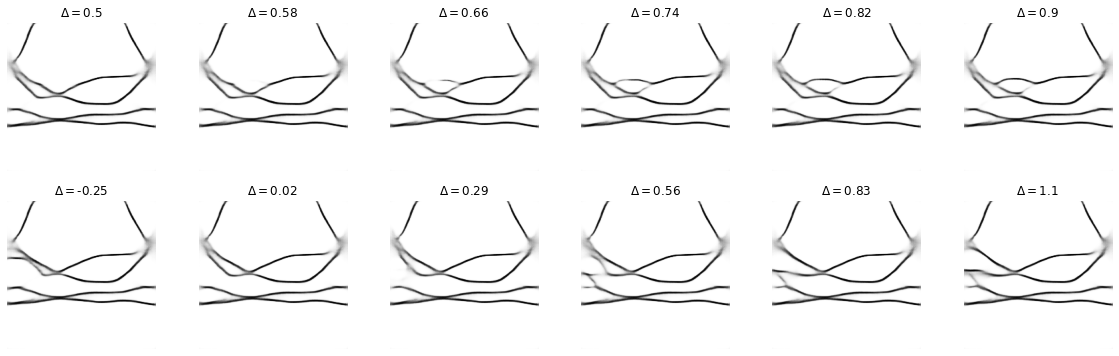

In [48]:
NUM_TRAVERSE_STEPS = 6
MAX_VARIATION = 0.7
z_dim = 98 # latent length 

# Assuming you have a trained beta-VAE model with encoder and decoder
# model is an instance of your beta-VAE model
# input_data is the input for which you want to visualize the latent space


resnet_input_file_type = "grayscale_4ev_linewidth3"
# change path to the location of the desired trained model
model_path = "../autoencoder/trained_models/resnet18_size224_lossbce_channels2.pkl"
resnet_model = load_learner(model_path)
#.format(FINGERPRINT_LENGTH)

latent_representation = run_resnet_one_mat("2dm-1", resnet_model, resnet_input_file_type)
print(latent_representation)
print(len(latent_representation))

# fig, ax  = plt.subplots()
# plt.title("Input")
# plt.imshow(input_data)
# plt.show()

latent_section = (3,3)


variation_from_mean = np.linspace(-MAX_VARIATION, MAX_VARIATION, NUM_TRAVERSE_STEPS)
mu = latent_representation

#FOR NORMAL AE
with torch.no_grad():
    out = resnet_model.decoder(mu)
#print(out[0,0])
#show_image(torch.sigmoid(out[0,0]))
#show_image(out)

iters = 2

fig, ax = plt.subplots(iters, NUM_TRAVERSE_STEPS, figsize=(20,6))

#print(mu[0, 1][latent_section_2])


# for j in range(iters):
#     ax[j, 0].set_ylabel(j)

for dim in range(iters):
    if dim==0:
        print("3")
        latent_section_2 = (2,2)
        variation_from_mean = np.linspace(0.5, 0.9, NUM_TRAVERSE_STEPS)
        ax[dim,0].set_ylabel("dimension=[2,2]")

    if dim==1:
        print("2")
        latent_section_2 = (3,0)
        #variation_from_mean = np.linspace(0.4, 1.8, NUM_TRAVERSE_STEPS)
        variation_from_mean = np.linspace(-0.25, 1.1, NUM_TRAVERSE_STEPS)
        ax[dim,0].set_ylabel("dimension=[3,0]")
    for j, variation in enumerate(variation_from_mean):


        mu_plus_variation = mu.clone()
        #latent_section[]
        mu_plus_variation[0, 1][latent_section_2] += variation*torch.ones(mu[0,1][latent_section_2].size())
        #mu_plus_variation[0, 0][latent_section_2] += variation*torch.ones(mu[0,0][latent_section_2].size())
        
        
        # FOR NORMAL AE
        with torch.no_grad():
            out = resnet_model.decoder(mu_plus_variation)
        #print(out[0,0])
        map_ = torch.sigmoid(out[0,0])
        show_image(1-map_, ax=ax[dim,j], cmap='Greys')
        #show_image(out)
    
        
    for i, variation in enumerate(variation_from_mean):
        ax[dim, i].set_title(r"$\Delta=${0}".format(round(variation, 2)))
       
fig.savefig("out1.png", bbox_inches="tight")
plt.show()

In [42]:
show_image?

Signature:
show_image(
    im,
    ax=None,
    figsize=None,
    title=None,
    ctx=None,
    *,
    cmap=None,
    norm=None,
    aspect=None,
    interpolation=None,
    alpha=None,
    vmin=None,
    vmax=None,
    origin=None,
    extent=None,
    interpolation_stage=None,
    filternorm=True,
    filterrad=4.0,
    resample=None,
    url=None,
    data=None,
    **kwargs,
)
Docstring: Show a PIL or PyTorch image on `ax`.
File:      /usr/local/lib/python3.9/dist-packages/fastai/torch_core.py
Type:      function
